In [1]:
# Librairies

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import dataset

data_dir = '../input/fruits/fruits-360'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training")
print('131 classes :', classes)

Folders : ['Test', 'test-multiple_fruits', 'LICENSE', 'readme.md', 'papers', 'Training']
131 classes : ['Apple Golden 3', 'Cocos', 'Pitahaya Red', 'Huckleberry', 'Pear Forelle', 'Strawberry Wedge', 'Mango', 'Maracuja', 'Avocado', 'Apple Golden 1', 'Blueberry', 'Nut Forest', 'Rambutan', 'Salak', 'Plum', 'Pineapple', 'Cucumber Ripe 2', 'Cantaloupe 1', 'Tomato Maroon', 'Beetroot', 'Strawberry', 'Banana Lady Finger', 'Cherry Wax Yellow', 'Pear Stone', 'Grape White 2', 'Tomato 3', 'Pineapple Mini', 'Tomato 4', 'Tomato Cherry Red', 'Pepper Orange', 'Pear 2', 'Pear Abate', 'Kiwi', 'Dates', 'Grapefruit White', 'Pepper Red', 'Apple Red Delicious', 'Cherry Wax Red', 'Mulberry', 'Grape White 3', 'Peach Flat', 'Clementine', 'Potato White', 'Onion Red', 'Tangelo', 'Mango Red', 'Tomato 1', 'Peach 2', 'Corn', 'Nut Pecan', 'Avocado ripe', 'Apple Red 1', 'Pepper Yellow', 'Nectarine Flat', 'Tomato 2', 'Orange', 'Hazelnut', 'Potato Red Washed', 'Tomato Yellow', 'Peach', 'Grape White 4', 'Banana Red', 'Ph

In [3]:
dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 67692


In [4]:
test = ImageFolder(data_dir + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of test dataset : 22688


Label:  Apple Braeburn (0)


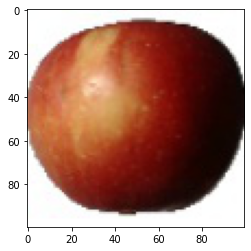

In [9]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[0])

In [10]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 100, 100])


Label:  Grape Blue (44)


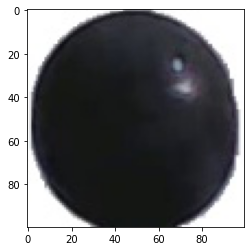

In [12]:
show_example(*dataset[22222])

In [13]:
torch.manual_seed(42)
val_size = 7000
train_size = len(dataset) - val_size

In [14]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(60692, 7000)

In [15]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

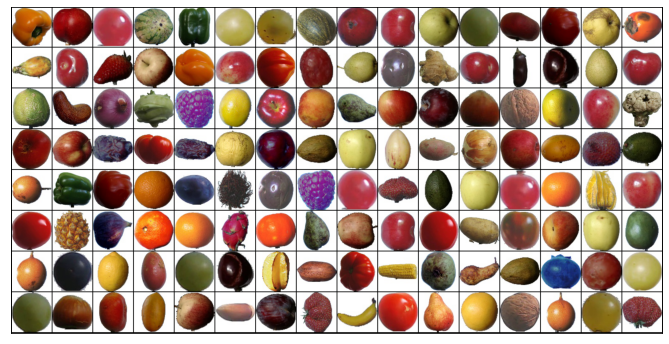

In [17]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# Using FeedFoward Neural Networks

In [18]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.2f}, val_acc: {:.2f}".format(epoch, result['val_loss'], result['val_acc']))

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
device=torch.cuda.is_available()

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [27]:
input_size = 3*100*100
output_size = 131 #classes

In [28]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [29]:
model = to_device(Model(input_size, output_size), device)

In [30]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 4.875705242156982, 'val_acc': 0.0068359375}]

In [31]:
history += fit(3, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 3.58, val_acc: 0.14
Epoch [1], val_loss: 2.66, val_acc: 0.27
Epoch [2], val_loss: 0.72, val_acc: 0.77


In [32]:
history += fit(3, 0.02, model, train_loader, val_loader)

Epoch [0], val_loss: 0.40, val_acc: 0.87
Epoch [1], val_loss: 1.89, val_acc: 0.61
Epoch [2], val_loss: 0.14, val_acc: 0.95


In [33]:
history += fit(3, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.07, val_acc: 0.98
Epoch [1], val_loss: 0.06, val_acc: 0.99
Epoch [2], val_loss: 0.06, val_acc: 0.99


In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

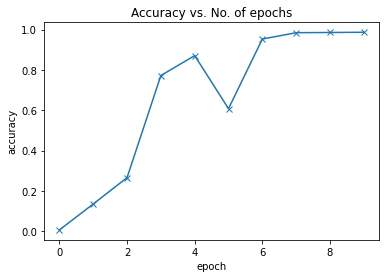

In [36]:
plot_accuracies(history)

In [37]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

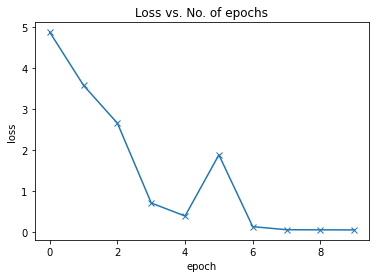

In [38]:
plot_losses(history)

In [39]:
evaluate(model, test_loader)

{'val_loss': 0.5018715262413025, 'val_acc': 0.8817504048347473}

# Using Convolutional Neural Networks

In [43]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [44]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
simple_model.cuda()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [45]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 100, 100])
out.shape: torch.Size([128, 8, 50, 50])


In [46]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [47]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 131))
        
    def forward(self, xb):
        return self.network(xb)

In [48]:
model = CnnModel()
model.cuda()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1000, out_features=5

In [49]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 100, 100])
out.shape: torch.Size([128, 131])
out[0]: tensor([ 0.0313, -0.0297, -0.0443, -0.0029, -0.0071, -0.0182, -0.0163, -0.0066,
        -0.0297,  0.0026, -0.0441, -0.0366, -0.0168,  0.0218,  0.0351, -0.0270,
         0.0224,  0.0163,  0.0171, -0.0173,  0.0470,  0.0424,  0.0177,  0.0152,
        -0.0046,  0.0034, -0.0076,  0.0093, -0.0297,  0.0049, -0.0189,  0.0080,
        -0.0174,  0.0036, -0.0250, -0.0012,  0.0113, -0.0453,  0.0348, -0.0493,
         0.0122, -0.0321, -0.0342,  0.0080, -0.0570, -0.0276,  0.0205,  0.0377,
         0.0355, -0.0464, -0.0044, -0.0365, -0.0283, -0.0221, -0.0175,  0.0180,
        -0.0324,  0.0430,  0.0466,  0.0242, -0.0190,  0.0436, -0.0520, -0.0077,
         0.0015,  0.0258, -0.0185,  0.0363,  0.0494, -0.0233, -0.0008,  0.0582,
         0.0078,  0.0174,  0.0083,  0.0369,  0.0209,  0.0213, -0.0171,  0.0277,
        -0.0012, -0.0232, -0.0041,  0.0151,  0.0273,  0.0250, -0.0085,  0.0192,
         0.0121, -0.0401,  0.0180

In [51]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [52]:
device = get_default_device()
device

device(type='cuda')

In [53]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [54]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [56]:
model = to_device(CnnModel(), device)

In [57]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

In [58]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.5703, val_loss: 0.0885, val_acc: 0.9709
Epoch [1], train_loss: 0.0797, val_loss: 0.0156, val_acc: 0.9958
Epoch [2], train_loss: 0.0431, val_loss: 0.0268, val_acc: 0.9920


In [59]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

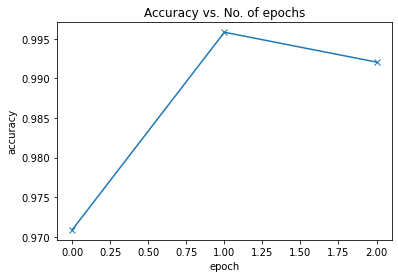

In [60]:
plot_accuracies(history)

In [61]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

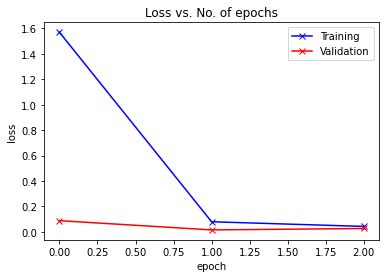

In [62]:
plot_losses(history)

In [63]:
evaluate(model, test_loader)

{'val_loss': 0.4535853862762451, 'val_acc': 0.9053722023963928}

In [64]:
project_name='Fruits360-Project'

In [65]:
!pip install jovian --upgrade -q

In [66]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/singhnaman985/Fruits360-Project


<IPython.core.display.Javascript object>